In [1]:
import numpy as np; import pandas as pd; 
import matplotlib.pyplot as plt; import xarray as xr;
import matplotlib.ticker as mticker
import os, sys, fsspec
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from datetime import datetime, timedelta

sys.path.append( '/home/noelgb/repositories/modview/modview')
import viztools

fs = fsspec.filesystem('local')

In [5]:
# Compute wind stress
def drag_coeff( wspeed ):
    Cd = 1.2e-3 * np.ones( wspeed.shape ); # ones
    faster = wspeed > 11; # meters per second
    Cd[faster] = ( 0.49 + 0.065 * wspeed.values[faster] ) * 1e-3
    fastest = wspeed > 25
    Cd[fastest] = 0.002;
    return Cd

def wstress( era_dat , surf = False):
    if surf:
        comp_vel = era_dat['u10'] + 1j*era_dat['v10']
    else:
        comp_vel = era_dat['u'].sel( pressure_level = 1000 ) + 1j * era_dat['v'].sel( pressure_level = 1000 )
    drag = drag_coeff( np.abs( comp_vel ) )
    stress = np.abs( comp_vel ) * drag * comp_vel * 1.22
    return stress

def vdiv( xr_obj ): 
    # compute vorticity and divergence from complex vector data
    divx = np.real( xr_obj ).differentiate( 'longitude' ) / ( 110e3 * np.cos( xr_obj['latitude'] / 180 * np.pi ) )
    divy = np.imag( xr_obj ).differentiate( 'latitude' ) / 110e3
    curl = np.imag( divx ) - np.real( divy )
    divv = np.real( divx ) + np.imag( divy )
    return curl, divv
                                        

In [6]:
data_folder = '/home/noelgb/data/ERA5/ClimateDataStore/frontal_storms/'

tc = xr.open_dataset( data_folder + 'mangkhut_plevels.nc' ).rename( {'valid_time':'time'} )
front = xr.open_dataset( data_folder + 'NorPac_front_plevels.nc' ).rename( {'valid_time':'time'})

# Load surface datasets
tc_surf = xr.open_dataset( 'mangkhut_surf_sup.nc' ).rename({'valid_time':'time'})
front_surf = xr.open_dataset( 'front_surf_sup.nc' ).rename({'valid_time':'time'})

tc_surf['tau'] = wstress( tc_surf , surf = True )
front_surf['tau'] = wstress( front_surf , surf = True )



In [7]:
front_surf

<xarray.Dataset>
Dimensions:    (time: 192, latitude: 29, longitude: 121)
Coordinates:
    number     int64 ...
  * time       (time) datetime64[ns] 2021-10-17 ... 2021-10-24T23:00:00
  * latitude   (latitude) float64 42.0 41.75 41.5 41.25 ... 35.5 35.25 35.0
  * longitude  (longitude) float64 210.0 210.2 210.5 210.8 ... 239.5 239.8 240.0
    expver     (time) <U4 ...
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 -6.89 -7.065 ... 3.824 3.108
    msl        (time, latitude, longitude) float32 ...
    tau        (time, latitude, longitude) complex128 (0.04379585194954869-0....
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-18T17:38 GRIB to CDM+CF via cfgrib-0.9.1...

<class 'cartopy.crs.PlateCarree'>
<class 'cartopy.crs.PlateCarree'>
<class 'cartopy.crs.PlateCarree'>
<class 'cartopy.crs.PlateCarree'>


/home/noelgb/.conda/envs/comp2023/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = super().contour(*args, **kwargs)
/home/noelgb/.conda/envs/comp2023/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = super().contour(*args, **kwargs)
/home/noelgb/.conda/envs/comp2023/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = super().contour(*args, **kwargs)
/home/noelgb/.conda/envs/comp2023/lib/python3.9/site-packages/cartopy/mpl/geoaxes.py:1604: UserWarning: The following kwargs were not used by contour: 'linestyle'
  result = super().contour(*args, **kwargs)
/home/noelgb/.conda/envs/comp2023/lib/python3.9/site-packages/cartopy/mpl/gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to

0
0
1
1


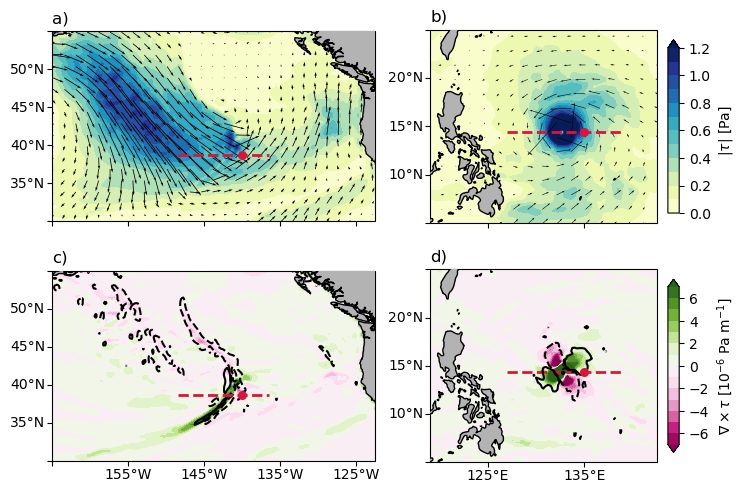

In [10]:
fd = {'figsize':[7.8,5.7], 'widths':[3,2.1], 'heights':[1,1], 
      'panels':[[0,0], [1,0], [0,1], [1,1]], 'projections':['PlateCarree']*4,
      'map_centers':[ [250,30], [250,30], [130,10], [130,10] ] }

fig = viztools.panel_plot( fd ); fig.draw(); ax = fig.axes; 

# -------- SETTINGS TO PLOT THE FRONTAL STORM
tind = 3; clat = 38.7;
sfc = front.isel( {'time':tind} );
tau = wstress( sfc )
vort, div = vdiv( tau )


vort = vort * 1e6

tau_contour = np.arange( 0, 1.21, 0.1 )
vort_contour = np.arange( -7, 7.01, 1 )

# PLOT THE FRONTAL STORM
img0 = ax[0].contourf( sfc['longitude'], sfc['latitude'], np.abs( tau ),
              cmap = 'YlGnBu', levels = tau_contour, extend = 'max', transform = ccrs.PlateCarree() )

sub_tau = tau.coarsen( {'longitude':6, 'latitude':6 } , boundary = 'pad' ).mean()
ax[0].quiver( sub_tau['longitude'], sub_tau['latitude'], np.real( sub_tau ).values, np.imag( sub_tau ).values , 
             color = 'black', scale = 8 , transform = ccrs.PlateCarree() )

img = ax[1].contourf( sfc['longitude'], sfc['latitude'], vort, cmap = 'PiYG', levels = vort_contour, 
                    extend = 'both' , transform = ccrs.PlateCarree() )
ax[1].contour( sfc['longitude'], sfc['latitude'], div, colors = 'k', levels = np.array([-1,-0.15])*1e-5, linestyle = 'dashed',
             transform = ccrs.PlateCarree() )
ax[1].contour( sfc['longitude'], sfc['latitude'], div, colors = 'k', levels = np.array([0.2,1])*1e-5, 
              linestyle = 'solid' , transform = ccrs.PlateCarree() )

# SPATIAL SUBSETTING
for jj in range(2):
    ax[jj].plot( [211.5, 223.5], [clat, clat], color = 'crimson', linestyle = 'dashed', linewidth = 2, 
               transform = ccrs.PlateCarree() )
    ax[jj].set_xlim([217.5,237.5]); ax[jj].set_ylim([0,25])
    ax[jj].set_extent([217.5,237.5,30,55], crs = ccrs.PlateCarree() )
    ax[jj].coastlines( facecolor = 'gray', zorder = 500 )
    ax[jj].scatter( [220], [clat], transform = ccrs.PlateCarree(), zorder = 400, s = 30, c = 'crimson' )


# -------- SETTINGS TO PLOT THE TC
tind = 3; clat = 14.4
sfc = tc.isel( {'time': tind  } )
tau = wstress( sfc )
vort, div = vdiv( tau )
vort = vort * 1e6

# -------- PLOT THE TC
img0 = ax[2].contourf( sfc['longitude'], sfc['latitude'], np.abs( tau ),
              cmap = 'YlGnBu', levels = tau_contour, extend = 'max', transform = ccrs.PlateCarree() )

sub_tau = tau.coarsen( {'longitude':6, 'latitude':6 } , boundary = 'pad' ).mean()
ax[2].quiver( sub_tau['longitude'], sub_tau['latitude'], np.real( sub_tau ).values, np.imag( sub_tau ).values , 
             color = 'black', scale = 8 , transform = ccrs.PlateCarree() )


# SPATIAL SUBSETTING
for jj in range(2):
    ax[jj+2].plot( [127, 139], [clat, clat], color = 'crimson', linestyle = 'dashed', linewidth = 2, 
               transform = ccrs.PlateCarree() )
    ax[jj+2].set_xlim([119,142.5]); ax[jj+2].set_ylim([0,25])
    ax[jj+2].set_extent([119,142.5,5,25], crs = ccrs.PlateCarree() )
    ax[jj+2].coastlines( facecolor = 'gray', zorder = 500 )
    
    ax[jj+2].scatter( [135], [clat], color = 'crimson', transform = ccrs.PlateCarree(), zorder = 400, s = 30 )
    
img1 = ax[3].contourf( sfc['longitude'], sfc['latitude'], vort, cmap = 'PiYG', levels = vort_contour , 
                    extend = 'both' , transform = ccrs.PlateCarree() )
ax[3].contour( sfc['longitude'], sfc['latitude'], div, colors = 'k', levels = np.array([-0.2])*1e-5, 
              linestyle = 'dashed', transform = ccrs.PlateCarree() )
ax[3].contour( sfc['longitude'], sfc['latitude'], div, colors = 'k', levels = np.array([0.2])*1e-5, 
              linestyle = 'solid', transform = ccrs.PlateCarree() )




bax0 = ax[2].inset_axes([1.05,0.05,0.05,0.9]); plt.colorbar( img0, cax = bax0, orientation = 'vertical', label = r'$| \tau |$ [Pa]' )
bax1 = ax[3].inset_axes([1.05,0.05,0.05,0.9]); 
plt.colorbar( img1 , cax = bax1, orientation='vertical', label = r'$\nabla \times \tau$ [10$^{-6}$ Pa m$^{-1}$]' )

ylocator = [[30,35,40,45,50,55], [5,10,15,20,25]]; xlocator = [ [-165,-155, -145, -135,-125],[125, 135] ]
labs = ['a)','c)','b)','d)']
for jj in range(4):
    
    axax = ax[jj];
    axax.add_feature(cfeature.LAND, facecolor = np.array([1,1,1])*0.7, zorder = 40 )
    axax.set_title( labs[jj], loc = 'left' )

    gl = axax.gridlines( crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='black', alpha=0 )
    gl.xlabels_top = False; gl.ylabels_right = False

    if jj in [0,2]:
        gl.xlabels_bottom = False 
    #gl.xlines = False
    row = int( np.floor( jj / 2 ) )
    print( row )
    axax.set_yticks( ylocator[row] , crs = ccrs.PlateCarree() )
    axax.set_xticks( xlocator[row] , crs = ccrs.PlateCarree() )
    axax.set_yticklabels([]); axax.set_xticklabels([])
    gl.ylocator = mticker.FixedLocator( ylocator[row] ) 
    gl.xlocator = mticker.FixedLocator( xlocator[row] )
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    #gl.xlabel_style = {'size': 15, 'color': 'gray'}
    #gl.xlabel_style = {'color': 'red', 'weight': 'bold'}


In [24]:
fig.fig.savefig('storm_viz.pdf', dpi = 250, bbox_inches = 'tight' )

2021-10-20 20:00:00
2018-09-12 18:00:00


Text(0.5, 0, 'Longitude')

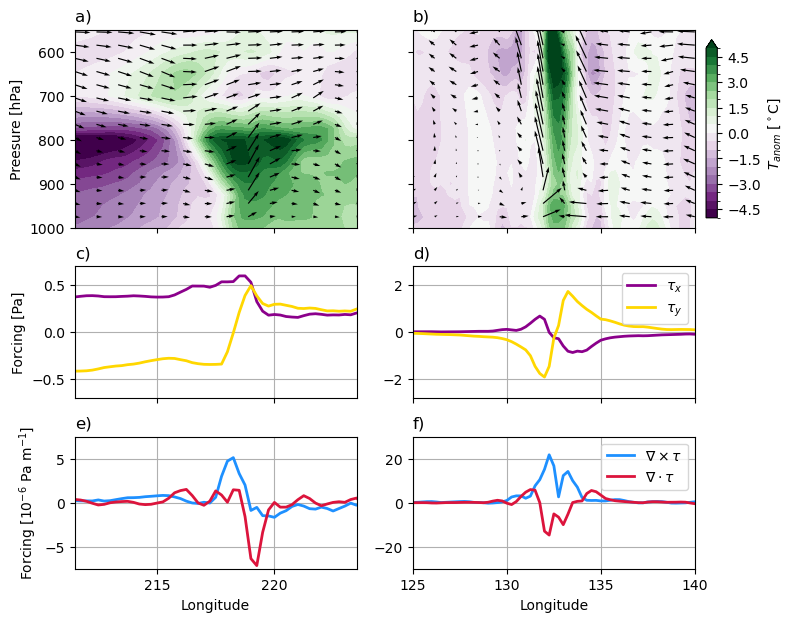

In [39]:
fd = {'figsize':[8,7], 'widths':[1,1], 'heights':[3,2,2], 
      'panels':[[0,0], [1,0], [2,0], [0,1], [1,1],[2,1] ], 'projections':[None]*6 }
fig = viztools.panel_plot( fd ); fig.draw(); 
ax = fig.axes
fig.fig.subplots_adjust(hspace=0.25)
#fig, ax = plt.subplots( figsize = [9,6], nrows = 3, ncols = 2 )

# Plot longitude, pressure section [[211.5,223.5]
sections = {'clat' : [38.7,14.4], 'xlims':[[211.5,223.5], [125,140]], 'ds':[front, tc], 
           'tind':[3,3], 'surf':[front_surf, tc_surf], 'xticks': [ np.arange(215,221,5), np.arange(125,141,5) ], 
           'conv_val' : [-6e-5, -6e-5] }

for col in range(2):
    clat = sections['clat'][col]; xlims = sections['xlims'][col]
    ds = sections['ds'][col]; fig_ind = ( col * 3)
    f = 4 * np.pi * np.sin( clat / 180 * np.pi ) / 24 / 3600
    timeval = pd.to_datetime( ds['time'][ sections['tind'][col] ].values )
    print( timeval )
    sliced = ds.interp( latitude = clat ).isel( time = sections['tind'][col] )
    #sliced = sliced.sel( longitude = slice( xlims[0], xlims[1] ) )

    #tanom = sliced['t'] - sliced['t'].mean('longitude')
    xvals = np.linspace( xlims[0], xlims[1], 14 )
    pvals = np.arange(975, 550, -30 ) 
    factor = 1;
    if col == 0:
        factor = 4; 
    tanom = sliced['t'].sel( longitude = slice( xlims[0]-1, xlims[1] +1) );
    tanom = tanom - tanom.mean('longitude')

    # PLOT TEMPERATURE SECTION
    uval = sliced['u'].interp( longitude = xvals ).interp( pressure_level = pvals )
    wval = sliced['w'].interp( longitude = xvals ).interp( pressure_level = pvals )

    img = tanom.plot.contourf( levels = np.arange( -5, 5.1, 0.5), yincrease = False, cmap = 'PRGn', ax = ax[ fig_ind ],
                   add_colorbar = False )

    ax[ fig_ind ].quiver( uval['longitude'] , uval['pressure_level'] , uval, - wval * 8 * factor )
    ax[ fig_ind ].set_ylim([1000,550])
    
    tau = sections['surf'][col]['tau'].sel( time = timeval + timedelta( hours = 0 ) )
    vort, div = vdiv( tau )
    lvort = vort.sel( latitude = clat , method = 'nearest' ); ldiv = div.sel( latitude = clat , method = 'nearest' )

    vort_label = r'$\nabla \times \tau$'; div_label = r'$\nabla \cdot \tau$'
    tx_label = r'$\tau_x$'; ty_label = r'$\tau_y$'

    (1e6  * lvort).plot( ax = ax[fig_ind + 2 ], label = vort_label , color = 'dodgerblue' , linewidth = 2 )
    (1e6  * ldiv).plot( ax = ax[ fig_ind + 2 ] , label = div_label , color = 'crimson' , linewidth = 2)
        
    ax[fig_ind + 2].set_ylim([-30/factor,30/factor]); ax[fig_ind+1].grid();
    ax[fig_ind + 1].set_ylim([-2.8/factor,2.8/factor]); ax[fig_ind+2].grid()

    tau = tau.sel( latitude = clat , method = 'nearest' )
    np.real( tau ).plot( ax = ax[ fig_ind + 1 ] , label = tx_label, color = 'darkmagenta' , linewidth = 2)
    np.imag( tau ).plot( ax = ax[ fig_ind + 1], label = ty_label, color = 'gold', linewidth = 2 ); 
    
    for jj in range(3):
        ax[ fig_ind + jj ].set_xlim( xlims );
        ax[ fig_ind + jj ].set_title('');
        ax[ fig_ind + jj ].set_xlabel(''); 
        ax[fig_ind+jj].set_xticks( sections['xticks'][col] )
        
        if jj < 2:
            ax[fig_ind + jj ].set_xticklabels([])


for lp in [4,5]:
    ax[lp].legend()

ax[0].set_ylabel('Preesure [hPa]')
ax[1].set_ylabel('Forcing [Pa]')
ax[2].set_ylabel('Forcing [10$^{-6}$ Pa m$^{-1}$]')
ax[4].set_ylabel(''); ax[3].set_ylabel(''); ax[3].set_yticklabels([])

labs = ['a)','c)','e)', 'b)','d)','f)'];
for jj in range(6):
    ax[jj].set_title( labs[jj] , loc = 'left' )

bax = ax[3].inset_axes([1.04,0.05,0.04,0.9])
plt.colorbar( img, cax = bax, orientation = 'vertical', label = '$T_{anom}$ [$^\circ$C]')
ax[2].set_xlabel('Longitude'); ax[5].set_xlabel('Longitude')

In [40]:
fig.fig.savefig('storm_sections.pdf', dpi = 250, bbox_inches = 'tight' )

In [20]:
15 *.8

12.0

In [43]:
xr.open_dataset( files[1] )

ValueError: did not find a match in any of xarray's currently installed IO backends ['netcdf4', 'h5netcdf', 'scipy', 'argo', 'gini', 'kerchunk', 'zarr']. Consider explicitly selecting one of the installed engines via the ``engine`` parameter, or installing additional IO dependencies, see:
https://docs.xarray.dev/en/stable/getting-started-guide/installing.html
https://docs.xarray.dev/en/stable/user-guide/io.html

In [44]:
files[1]

'/home/noelgb/data/ERA5/ClimateDataStore/frontal_storms/mangkhut_surf.nc'

In [8]:
import cdsapi

client = cdsapi.Client()

dataset = 'reanalysis-era5-single-levels'
request = {
      'product_type': ['reanalysis'],
      'variable': ['10m_u_component_of_wind','10m_v_component_of_wind' ],
      'year': ['2018'],
      'month': ['09'],
      'day': ['10','11','12','13','14','15'],
      'time': ['00:00','01:00','02:00','03:00',
               '04:00','05:00','06:00','07:00',
               '08:00','09:00','10:00','11:00',
               '12:00','13:00','14:00','15:00',
               '16:00','17:00','18:00','19:00',
               '20:00','21:00','22:00','23:00'],
      'data_format': 'netcdf',
      'area':['25','100','0','170'],
      'download_format': 'unarchived',
  }
target = 'mangkhut_surf_sup.nc'
  
client.retrieve(dataset, request, target)


2024-10-11 14:00:54,705 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T in July 2024 - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-10-11 14:00:54,706 WARNING [2024-10-11T18:00:54.628465] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2024-10-11 14:00:54,707 INFO Request ID is c9f5cc6f-149f-4fcb-ad2d-cf8eb811f7d3
2024-10-11 14:00:54,845 INFO status has been updated to accepted
2024-10-11 14:00:58,874 INFO status has been updated to running
2024-10-11 14:01:27,146 INFO status has been updated to successful


424c4fd9d7430089714c4fb517302142.nc:   0%|          | 0.00/16.7M [00:00<?, ?B/s]

'mangkhut_surf_sup.nc'

In [6]:
ds = xr.open_dataset( 'mangkhut_surf2.nc' )

In [5]:
front_surf

<xarray.Dataset>
Dimensions:    (time: 192, latitude: 17, longitude: 105)
Coordinates:
    number     int64 ...
  * time       (time) datetime64[ns] 2021-10-17 ... 2021-10-24T23:00:00
  * latitude   (latitude) float64 42.0 41.75 41.5 41.25 ... 38.5 38.25 38.0
  * longitude  (longitude) float64 222.0 222.2 222.5 222.8 ... 247.5 247.8 248.0
    expver     (time) <U4 ...
Data variables:
    u10        (time, latitude, longitude) float32 ...
    v10        (time, latitude, longitude) float32 -7.497 -7.128 ... 4.171 4.548
    tau        (time, latitude, longitude) complex128 (0.154302429713164-0.13...
Attributes:
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2024-10-14T18:43 GRIB to CDM+CF via cfgrib-0.9.1...

In [3]:
import cdsapi

client = cdsapi.Client()

dataset = 'reanalysis-era5-single-levels'
request = {
      'product_type': ['reanalysis'],
      'variable': ['10m_u_component_of_wind','10m_v_component_of_wind', 
                  'mean_sea_level_pressure'],
      'year': ['2021'],
      'month': ['10'],
      'day': ['17','18','19','20','21','22','23','24'],
      'time': ['00:00','01:00','02:00','03:00',
               '04:00','05:00','06:00','07:00',
               '08:00','09:00','10:00','11:00',
               '12:00','13:00','14:00','15:00',
               '16:00','17:00','18:00','19:00',
               '20:00','21:00','22:00','23:00'],
      'data_format': 'netcdf',
      'area':['42','210','35','240'],
      'download_format': 'unarchived',
  }
target = 'front_surf_sup.nc'

client.retrieve(dataset, request, target)


2024-10-18 13:37:09,567 WARNING [2024-10-10T00:00:00] The final validated ERA5 differs from ERA5T in July 2024 - please refer to our
[Forum announcement](https://forum.ecmwf.int/t/final-validated-era5-product-to-differ-from-era5t-in-july-2024/6685)
for details and watch it for further updates on this.
2024-10-18 13:37:09,569 WARNING [2024-10-18T17:37:09.444838] You are using a deprecated API endpoint. If you are using cdsapi, please upgrade to the latest version.
2024-10-18 13:37:09,570 INFO Request ID is ebc9b0d0-24ea-4b37-9b7f-373ce5862be9
2024-10-18 13:37:09,703 INFO status has been updated to accepted
2024-10-18 13:37:13,844 INFO status has been updated to running
2024-10-18 13:38:25,022 INFO status has been updated to successful


58b544fa31e7b8e6df825a8719ec12ac.nc:   0%|          | 0.00/3.72M [00:00<?, ?B/s]

'front_surf_sup.nc'

In [22]:
front_surf['longitude']

<xarray.DataArray 'longitude' (longitude: 25)>
array([222.  , 222.25, 222.5 , 222.75, 223.  , 223.25, 223.5 , 223.75, 224.  ,
       224.25, 224.5 , 224.75, 225.  , 225.25, 225.5 , 225.75, 226.  , 226.25,
       226.5 , 226.75, 227.  , 227.25, 227.5 , 227.75, 228.  ])
Coordinates:
    number     int64 ...
  * longitude  (longitude) float64 222.0 222.2 222.5 222.8 ... 227.5 227.8 228.0
Attributes:
    units:          degrees_east
    standard_name:  longitude
    long_name:      longitude